# API demonstration for paper of v1.0

_the LSST-DESC CLMM team_


Here we demonstrate how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster when source galaxies follow a given distribution (The LSST DESC Science Requirements Document - arXiv:1809.01669,  implemented in `clmm`). It uses several functionalities of the support `mock_data` module to produce mock datasets.

- Setting things up, with the proper imports.
- Computing the binned reduced tangential shear profile, for the 2 datasets, using logarithmic binning.
- Setting up a model accounting for the redshift distribution.
- Perform a simple fit using `scipy.optimize.curve_fit` included in `clmm` and visualize the results.

## Setup

First, we import some standard packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = ['gothambook','gotham','gotham-book','serif']

## Generating mock data

`clmm` has a support code to generate a mock catalog given a input cosmology and cluster parameters. We will use this to generate a data sample to be used in this example:

In [2]:
from clmm import Cosmology
import clmm.support.mock_data as mock

In [4]:
np.random.seed(14) # For reproducibility

# Set cosmology of mock data
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)

# Cluster info
cluster_m = 1.e15 # Cluster mass - ($M200_m$) [Msun]
concentration = 4  # Cluster concentration
cluster_z = 0.3 # Cluster redshift
cluster_ra = 0. # Cluster Ra in deg
cluster_dec = 0. # Cluster Dec in deg

# Catalog info
field_size = 10 # i.e. 10 x 10 Mpc field at the cluster redshift, cluster in the center

# Make mock galaxies
mock_galaxies = mock.generate_galaxy_catalog(
    cluster_m=cluster_m, cluster_z=cluster_z, cluster_c=concentration, # Cluster data
    cosmo=cosmo, # Cosmology object
    zsrc='desc_srd', # Galaxy redshift distribution, 
    zsrc_min=0.4, # Minimum redshift of the galaxies
    shapenoise=0.05, # Gaussian shape noise to the galaxy shapes
    photoz_sigma_unscaled=0.05, # Photo-z errors to source redshifts
    field_size=field_size,
    ngal_density=20 # number of gal/arcmin2 for z in [0, infty]
)['ra', 'dec', 'e1', 'e2', 'z', 'ztrue', 'pzbins', 'pzpdf', 'id']
print(f'Catalog table with the columns: {", ".join(mock_galaxies.colnames)}')

ngals_init = len(mock_galaxies)
print(f'Initial number of galaxies: {ngals_init:,}')

# Keeping only galaxies with "measured" redshift greater than cluster redshift
mock_galaxies = mock_galaxies[(mock_galaxies['z']>cluster_z)]
ngals_good = len(mock_galaxies)

if ngals_good < ngals_init:
    print(f'Number of excluded galaxies (with photoz < cluster_z): {ngals_init-ngals_good:,}')
    # reset galaxy id for later use
    mock_galaxies['id'] = np.arange(ngals_good)

# Check final density
from clmm.utils import convert_units
field_size_arcmin = convert_units(field_size, 'Mpc', 'arcmin', redshift=cluster_z, cosmo=cosmo)
print(f'Background galaxy density = {ngals_good/field_size_arcmin**2:.2f} gal/arcmin2\n')

Catalog table with the columns: ra, dec, e1, e2, z, ztrue, pzbins, pzpdf, id
Initial number of galaxies: 24,531
Number of excluded galaxies (with photoz < cluster_z): 44
Background galaxy density = 17.71 gal/arcmin2



We can extract the column of this mock catalog to show explicitely how the quantities can be used on `clmm` functionality and how to add them to a `GalaxyCluster` object: 

In [5]:
# Put galaxy values on arrays
gal_ra = mock_galaxies['ra'] # Galaxies Ra in deg
gal_dec = mock_galaxies['dec'] # Galaxies Dec in deg
gal_e1 = mock_galaxies['e1'] # Galaxies elipticipy 1
gal_e2 = mock_galaxies['e2'] # Galaxies elipticipy 2
gal_z = mock_galaxies['z'] # Galaxies observed redshift
gal_ztrue = mock_galaxies['ztrue'] # Galaxies true redshift
gal_pzbins = mock_galaxies['pzbins'] # Galaxies P(z) bins  
gal_pzpdf = mock_galaxies['pzpdf'] # Galaxies P(z)
gal_id = mock_galaxies['id'] # Galaxies ID

## Measuring shear profiles 

From the source galaxy quantities, we can compute the elepticities and corresponding radial profile usimg `clmm.dataops` functions:

In [6]:
import clmm.dataops as da

In [7]:
# Convert elipticities into shears
gal_ang_dist, gal_gt, gal_gx = da.compute_tangential_and_cross_components(cluster_ra, cluster_dec,
                                                                          gal_ra, gal_dec,
                                                                          gal_e1, gal_e2,
                                                                          geometry="flat")

# Measure profile
profile = da.make_radial_profile([gal_gt, gal_gx, gal_z],
                                 gal_ang_dist, "radians", "Mpc",
                                 bins=da.make_bins(0.01, field_size/2., 50),
                                 cosmo=cosmo,
                                 z_lens=cluster_z,
                                 include_empty_bins=False)
print(f'Profile table has columns: {", ".join(profile.colnames)},')
print('where p_(0, 1, 2) = (gt, gx, z)')

Profile table has columns: radius_min, radius, radius_max, p_0, p_0_err, p_1, p_1_err, p_2, p_2_err, n_src,
where p_(0, 1, 2) = (gt, gx, z)


The other possibility is to use the `GalaxyCluster` object. This is the main approach to handle data with `clmm`, and also the simpler way. For that you just have to provide the following information of the cluster:

* Ra, Dec [deg]
* Mass - ($M200_m$) [Msun]
* Concentration
* Redshift


and the source galaxies:

* Ra, Dec [deg]
* 2 axis of eliptticities
* Redshift



In [8]:
import clmm

In [9]:
# Create a GCData with the galaxies
galaxies = clmm.GCData([gal_ra, gal_dec, gal_e1, gal_e2, gal_z,
                        gal_ztrue, gal_pzbins, gal_pzpdf, gal_id],
                      names=['ra', 'dec', 'e1', 'e2', 'z',
                             'ztrue', 'pzbins', 'pzpdf', 'id'])

# Create a GalaxyCluster
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec,
                                   cluster_z, mock_galaxies)

# Convert elipticities into shears for the members
cluster.compute_tangential_and_cross_components(geometry="flat")
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster
seps = convert_units(cluster.galcat['theta'], 'radians', 'mpc',cluster.z, cosmo)

cluster.make_radial_profile(bins=da.make_bins(0.1, field_size/2., 25, method='evenlog10width'),
                            bin_units="Mpc",
                            cosmo=cosmo,
                            include_empty_bins=False,
                            gal_ids_in_bins=True,
                           )
print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'ztrue', 'pzbins', 'pzpdf', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'gal_id']


This results in an attribute `table` added to the `cluster` object.

[3.543307086614173, 3.543307086614173]


<Figure size 432x288 with 0 Axes>

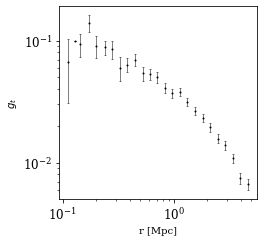

In [10]:
import sys
sys.path.append('Paper_v1.0') 
from paper_formating import prep_plot
prep_plot(figsize=(9, 9))
#plt.figure(figsize=(9, 9))
errorbar_kwargs = dict(linestyle='', marker='o',
    markersize=1, elinewidth=.5, capthick=.5)
plt.errorbar(cluster.profile['radius'], cluster.profile['gt'],
             cluster.profile['gt_err'], c='k', **errorbar_kwargs)
plt.xlabel('r [Mpc]', fontsize = 10)
plt.ylabel(r'$g_t$', fontsize = 10)
plt.xscale('log')
plt.yscale('log')

## Theoretical predictions

We consider 3 models:
1. One model where all sources are considered at the same redshift
2. One model using the overall source redshift distribution to predict the reduced tangential shear
3. A more accurate model, relying on the fact that we have access to the individual redshifts of the sources, where the average reduced tangential shear is averaged independently in each bin, accounting for the acutal population of sources in each bin.

All models rely on `clmm.predict_reduced_tangential_shear` to make a prediction that accounts for the redshift distribution of the galaxies in each radial bin:

### Model considering all sources located at the average redshift
\begin{equation}
     g_{t,i}^{\rm{avg(z)}} = g_t(R_i, \langle z \rangle)\;,
 \label{eq:wrong_gt_model}
 \end{equation} 

In [11]:
def predict_reduced_tangential_shear_mean_z(profile, logm):
    return clmm.compute_reduced_tangential_shear(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=np.mean(cluster.galcat['z']), # Mean value of source galaxies redshift
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'
        )

### Model relying on the overall redshift distribution of the sources N(z), not using individual redshift information (eq. (6) from Applegate et al. 2014, MNRAS, 439, 48) 
\begin{equation}
     g_{t,i}^{N(z)} = \frac{\langle\beta_s\rangle \gamma_t(R_i, z\rightarrow\infty)}{1-\frac{\langle\beta_s^2\rangle}{\langle\beta_s\rangle}\kappa(R_i, z\rightarrow\infty)}
     \label{eq:approx_model}
 \end{equation}

In [12]:
z_inf = 1000.
dl_inf = cosmo.eval_da_z1z2(cluster_z, z_inf)
d_inf = cosmo.eval_da(z_inf)

def betas(z):
    dls = cosmo.eval_da_z1z2(cluster_z, z)
    ds = cosmo.eval_da(z)
    return dls * d_inf / (ds * dl_inf)

def predict_reduced_tangential_shear_approx(profile, logm):

    bs_mean = np.mean(betas(cluster.galcat['z'])) 
    bs2_mean = np.mean(betas(cluster.galcat['z'])**2)

    gamma_t_inf = clmm.compute_tangential_shear(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value at infinity
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw')
    convergence_inf = clmm.compute_convergence(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value at infinity
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw')
        
    return bs_mean*gamma_t_inf/(1-(bs2_mean/bs_mean)*convergence_inf)       

In [13]:
def predict_reduced_tangential_shear_approx_new(profile, logm):

    bs_mean = np.mean(betas(cluster.galcat['z'])) 
    bs2_mean = np.mean(betas(cluster.galcat['z'])**2)
    
    return clmm.compute_reduced_tangential_shear(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=1000., # this is arbitrary 
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw',
            z_src_model='weighing_the_giants_b',
            beta_s_mean=bs_mean,
            beta_s_square_mean=bs2_mean,
        )

### Model using individual redshift and radial information, to compute the averaged shear in each radial bin, based on the galaxies actually present in that bin.
\begin{equation}
    g_{t,i}^{z, R} = \frac{1}{N_i}\sum_{{\rm gal\,}j\in {\rm bin\,}i} g_t(R_j, z_j)
    \label{eq:exact_model}
 \end{equation}

In [14]:
cluster.galcat['theta_mpc'] = convert_units(cluster.galcat['theta'], 'radians', 'mpc',cluster.z, cosmo)

def predict_reduced_tangential_shear_exact(profile, logm):
    return np.array([np.mean(
        clmm.compute_reduced_tangential_shear(
            # Radial component of each source galaxy inside the radial bin
            r_proj=cluster.galcat[radial_bin['gal_id']]['theta_mpc'],
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=4, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            # Redshift value of each source galaxy inside the radial bin
            z_source=cluster.galcat[radial_bin['gal_id']]['z'],
            cosmo=cosmo,
            delta_mdef=200,
            halo_profile_model='nfw'
        )) for radial_bin in profile])

## Mass fitting

We estimate the best-fit mass using `scipy.optimize.curve_fit`. The choice of fitting $\log M$ instead of $M$ lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error $\sigma_{\log M}$ we calculate the error to mass as $\sigma_M = M_{fit}\ln(10)\sigma_{\log M}$.

#### First, identify bins with sufficient galaxy statistics to be kept for the fit
For small samples, error bars should not be computed using the simple error on the mean approach available so far in CLMM)



In [15]:
mask_for_fit = cluster.profile['n_src'] > 5
data_for_fit = cluster.profile[mask_for_fit]

#### Perform the fits


In [16]:
from clmm.support.sampler import fitters
def fit_mass(predict_function):
    popt, pcov = fitters['curve_fit'](predict_function,
        data_for_fit, 
        data_for_fit['gt'], 
        data_for_fit['gt_err'], bounds=[10.,17.])
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [17]:
fit_mean_z = fit_mass(predict_reduced_tangential_shear_mean_z)
fit_approx = fit_mass(predict_reduced_tangential_shear_approx)
fit_approx_new = fit_mass(predict_reduced_tangential_shear_approx_new)
fit_exact = fit_mass(predict_reduced_tangential_shear_exact)

In [18]:
print(f'Input mass = {cluster_m:.2e} Msun\n')

print(f'Best fit mass for average redshift               = {fit_mean_z["m"]:.3e} +/- {fit_mean_z["m_err"]:.3e} Msun')
print(f'Best fit mass for N(z) model                     = {fit_approx["m"]:.3e} +/- {fit_approx["m_err"]:.3e} Msun')
print(f'Best fit mass for N(z) model new                 = {fit_approx_new["m"]:.3e} +/- {fit_approx_new["m_err"]:.3e} Msun')
print(f'Best fit mass for individual redshift and radius = {fit_exact["m"]:.3e} +/- {fit_exact["m_err"]:.3e} Msun')

Input mass = 1.00e+15 Msun

Best fit mass for average redshift               = 8.778e+14 +/- 2.807e+13 Msun
Best fit mass for N(z) model                     = 1.028e+15 +/- 3.305e+13 Msun
Best fit mass for N(z) model new                 = 9.881e+14 +/- 3.170e+13 Msun
Best fit mass for individual redshift and radius = 1.024e+15 +/- 3.294e+13 Msun


As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses for noisy and ideal data.

In [18]:
def get_predicted_shear(predict_function, fit_values):
    gt_est = predict_function(data_for_fit, fit_values['logm'])
    gt_est_err = [predict_function(data_for_fit, fit_values['logm']+i*fit_values['logm_err'])
                          for i in (-3, 3)]
    return gt_est, gt_est_err

In [19]:
gt_mean_z, gt_err_mean_z =  get_predicted_shear(predict_reduced_tangential_shear_mean_z, fit_mean_z)
gt_approx, gt_err_approx =  get_predicted_shear(predict_reduced_tangential_shear_approx, fit_approx)
gt_approx_new, gt_err_approx_new =  get_predicted_shear(predict_reduced_tangential_shear_approx_new, fit_approx_new)
gt_exact, gt_err_exact =  get_predicted_shear(predict_reduced_tangential_shear_exact, fit_exact)

Check reduced chi2 values of the best-fit model

In [20]:
chi2_mean_z_dof = np.sum((gt_mean_z-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)
chi2_approx_dof = np.sum((gt_approx-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)
chi2_approx_new_dof = np.sum((gt_approx_new-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)
chi2_exact_dof = np.sum((gt_exact-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)

print(f'Reduced chi2 (mean z model) = {chi2_mean_z_dof}')
print(f'Reduced chi2 (N(z) model) = {chi2_approx_dof}')
print(f'Reduced chi2 (N(z) model new) = {chi2_approx_new_dof}')
print(f'Reduced chi2 (individual (R,z) model) = {chi2_exact_dof}')

Reduced chi2 (mean z model) = 0.7118551142316918
Reduced chi2 (N(z) model) = 0.6412742361696046
Reduced chi2 (N(z) model new) = 0.6412742361696046
Reduced chi2 (individual (R,z) model) = 0.6491209881704794


We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model then for the naive approach, with respective best-fit masses.

[3.543307086614173, 3.543307086614173]


<Figure size 1800x1200 with 0 Axes>

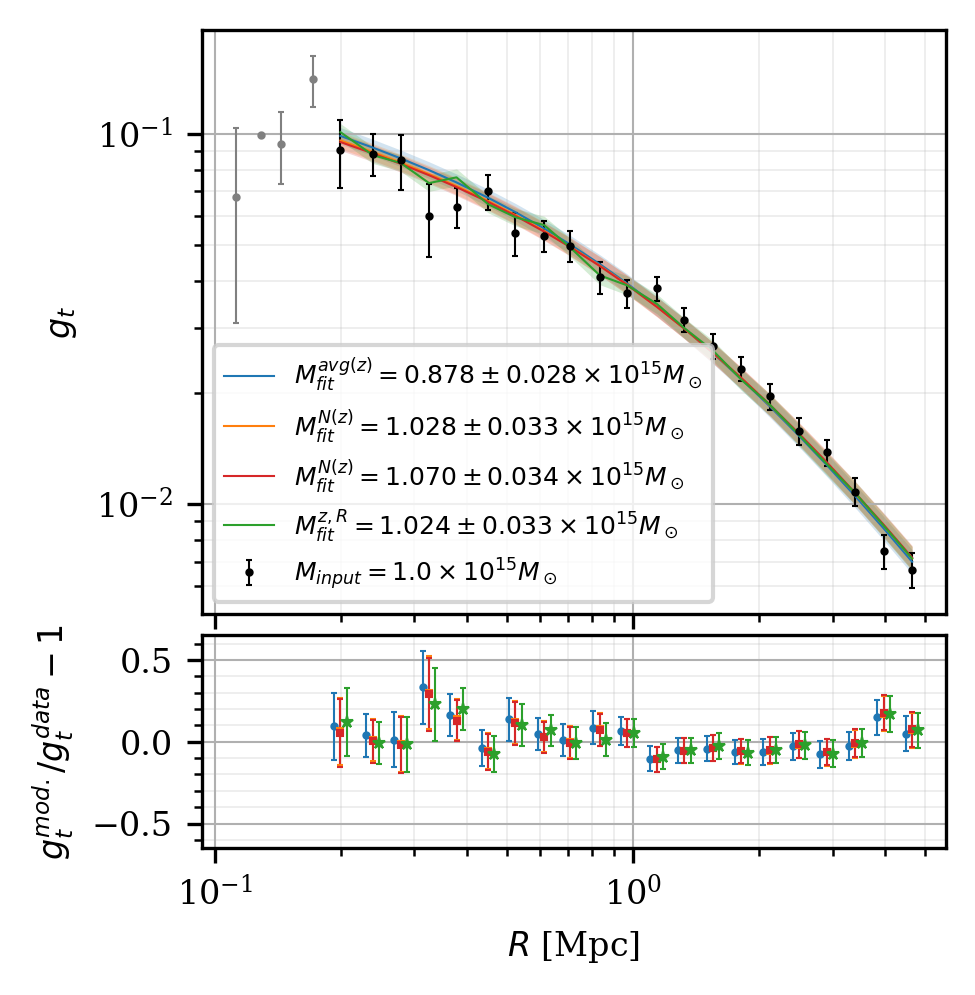

In [35]:
from matplotlib.ticker import MultipleLocator

#from paper_formating import prep_plot
prep_plot(figsize=(9 , 9))
#plt.figure(figsize=(9 , 9))

gt_ax = plt.axes([.25, .42, .7, .55])
gt_ax.errorbar(data_for_fit['radius'],data_for_fit['gt'], data_for_fit['gt_err'],
             c='k', label=rf'$M_{{input}} = {cluster_m*1e-15}\times10^{{{15}}} M_\odot$',
            **errorbar_kwargs)

# Points in grey have not been used for the fit
gt_ax.errorbar(cluster.profile['radius'][~mask_for_fit], cluster.profile['gt'][~mask_for_fit],
               cluster.profile['gt_err'][~mask_for_fit], 
               c='grey',**errorbar_kwargs)

pow10 = 15
mlabel = lambda name, fits: fr'$M_{{fit}}^{{{name}}} = {fits["m"]/10**pow10:.3f}\pm{fits["m_err"]/10**pow10:.3f}\times 10^{{{pow10}}} M_\odot$'
# Avg z
gt_ax.loglog(data_for_fit['radius'], gt_mean_z,'-C0', 
           label=mlabel('avg(z)', fit_mean_z),lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_mean_z, lw=0, color='C0', alpha=.2)
# Approx model
gt_ax.loglog(data_for_fit['radius'], gt_approx,'-C1', 
           label=mlabel('N(z)', fit_approx),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_approx, lw=0, color='C1', alpha=.2)
# Approx model new
gt_ax.loglog(data_for_fit['radius'], gt_approx_new,'-C3', 
           label=mlabel('N(z)', fit_approx_new),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_approx_new, lw=0, color='C3', alpha=.2)
# Exact model
gt_ax.loglog(data_for_fit['radius'], gt_exact,'-C2', 
           label=mlabel('z,R', fit_exact),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_exact, lw=0, color='C2', alpha=.2)


gt_ax.set_ylabel(r'$g_t$', fontsize = 8)
gt_ax.legend(fontsize=6)
gt_ax.set_xticklabels([])
gt_ax.tick_params('x', labelsize=8)
gt_ax.tick_params('y', labelsize=8)

#gt_ax.set_yscale('log')
errorbar_kwargs2 = {k:v for k, v in errorbar_kwargs.items() if 'marker' not in k}
errorbar_kwargs2['markersize'] = 3
errorbar_kwargs2['markeredgewidth'] = .5
res_ax = plt.axes([.25, .2, .7, .2])
delta = (cluster.profile['radius'][1]/cluster.profile['radius'][0])**.25
res_err = data_for_fit['gt_err']/data_for_fit['gt']
res_ax.errorbar(data_for_fit['radius']/delta, gt_mean_z/data_for_fit['gt']-1,
                yerr=res_err, marker='.', c='C0', **errorbar_kwargs2)
errorbar_kwargs2['markersize'] = 1.5
res_ax.errorbar(data_for_fit['radius'], gt_approx/data_for_fit['gt']-1,
                yerr=res_err, marker='s', c='C1', **errorbar_kwargs2)
res_ax.errorbar(data_for_fit['radius'], gt_approx_new/data_for_fit['gt']-1,
                yerr=res_err, marker='s', c='C3', **errorbar_kwargs2)
errorbar_kwargs2['markersize'] = 3
errorbar_kwargs2['markeredgewidth'] = .5
res_ax.errorbar(data_for_fit['radius']*delta, gt_exact/data_for_fit['gt']-1,
                yerr=res_err, marker='*', c='C2', **errorbar_kwargs2)
res_ax.set_xlabel(r'$R$ [Mpc]', fontsize = 8)

res_ax.set_ylabel(r'$g_t^{mod.}/g_t^{data}-1$', fontsize = 8)
res_ax.set_xscale('log')
res_ax.set_xlim(gt_ax.get_xlim())
res_ax.set_ylim(-0.65,0.65)
res_ax.yaxis.set_minor_locator(MultipleLocator(.1))

res_ax.tick_params('x', labelsize=8)
res_ax.tick_params('y', labelsize=8)

for p in (gt_ax, res_ax):
    p.xaxis.grid(True, which='major', lw=.5)
    p.yaxis.grid(True, which='major', lw=.5)
    p.xaxis.grid(True, which='minor', lw=.1)
    p.yaxis.grid(True, which='minor', lw=.1)

plt.savefig('r_gt.png')